# Генерация заголовков научных статей

In [1]:
import torch
torch.cuda.get_device_name()

'Tesla P100-PCIE-16GB'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Источник: https://github.com/bentrevett/pytorch-seq2seq

## Import packages

In [3]:
!pip install -q pyicu
!pip install -q pycld2
!pip install -q polyglot
!pip install transformers

     |████████████████████████████████| 235kB 3.5MB/s 
     |████████████████████████████████| 41.4MB 73kB/s 
     |████████████████████████████████| 133kB 3.2MB/s 
     |████████████████████████████████| 665kB 3.4MB/s 
     |████████████████████████████████| 1.1MB 53.5MB/s 
     |████████████████████████████████| 3.8MB 48.4MB/s 
     |████████████████████████████████| 890kB 61.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=cfb3e7dab912dfc426d6698697352bb383e533ff8b27a23b34eee6793b4dd059
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [4]:
from transformers import BartTokenizer, BartForConditionalGeneration, AdamW

import pandas as pd
import numpy as np
import re
import string
import collections

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchtext.data import Field, NestedField, BucketIterator
from torchtext import data, vocab

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.pyplot import figure

import spacy
from polyglot.detect import Detector

import seaborn as sns
from tqdm import tqdm
import matplotlib.cm as cm

tqdm.pandas()

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import random
import math
import time

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Prepare Data


In [6]:
# let's train model on a part of train.csv to speed up computations

#train_df = pd.read_csv('/content/drive/My Drive/train.csv').head(30001)
#train_df.to_csv('/content/drive/My Drive/train_small.csv', index=False)

train_df = pd.read_csv('/content/drive/My Drive/train.csv')
train_df.head()

,abstract,title
0,we consider the problem of utility maximizatio...,on optimal investment with processes of long o...
1,in this paper we provide an explicit formula f...,boolean complexes for ferrers graphs
2,"kinesin-5, also known as eg5 in vertebrates is...",relative velocity of sliding of microtubules b...
3,we discuss the transition paths in a coupled b...,bifurcation of transition paths induced by cou...
4,two types of room temperature detectors of ter...,all-electric detectors of the polarization sta...


## Word lengths



In [0]:
pattern = r"\S+"

splited_abstracts = [re.findall(pattern, abstract) for abstract in train_df['abstract']]
splited_titles = [re.findall(pattern, title) for title in train_df['title']]

In [0]:
def count_word_lens(splited_sequences):
  lens = []
  for seq in splited_sequences:
    for token in seq:
      lens.append(len(token))
  return lens

all_abstract_words_lens = count_word_lens(splited_abstracts)
all_title_words_lens = count_word_lens(splited_titles)

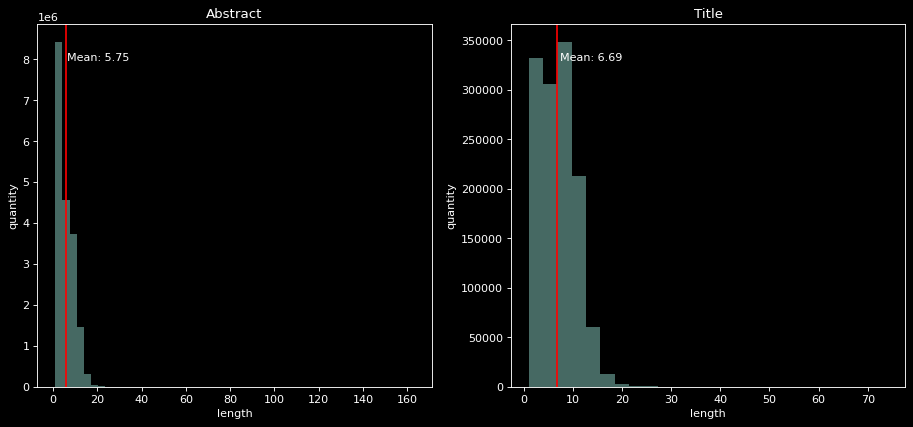

In [0]:
plt.style.use('dark_background')

figure(num=None, figsize=(14, 6), dpi=80, edgecolor='k')

plt.subplot(1, 2, 1)
plt.axvline(x=np.mean(all_abstract_words_lens), color='red', linestyle='-')
plt.hist(all_abstract_words_lens, bins=50, alpha=0.5,
            histtype='stepfilled',
            edgecolor='none')
plt.title("Abstract")
plt.ylabel('quantity')
plt.xlabel('length')

min_ylim, max_ylim = plt.ylim()
plt.text(np.mean(all_abstract_words_lens)*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(np.mean(all_abstract_words_lens)));

plt.subplot(1, 2, 2)
plt.axvline(x=np.mean(all_title_words_lens), color='red', linestyle='-')
plt.hist(all_title_words_lens, bins=25, alpha=0.5,
            histtype='stepfilled',
            edgecolor='none')
plt.title("Title")
plt.ylabel('quantity')
plt.xlabel('length')

min_ylim, max_ylim = plt.ylim()
plt.text(np.mean(all_title_words_lens)*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(np.mean(all_title_words_lens)));

## Delete longest words

In [0]:
splited_abstracts = [[token for token in splited_abstracts[i] if len(token)<22] for i in range(len(splited_abstracts))]
splited_titles = [[token for token in splited_titles[i] if len(token)<22] for i in range(len(splited_abstracts))]

filtred_df = pd.DataFrame({'abstract' : [' '.join(splited_abstracts[i]) for i in range(len(splited_abstracts))],
                          'title' :  [' '.join(splited_titles[i]) for i in range(len(splited_titles))]})

## Find title words entry position in abstract

In [0]:
pattern = r"\w+-\w+-\w+|\w+-\w+|\w+'\w+|\w+"

splited_abstracts = [re.findall(pattern, abstract) for abstract in filtred_df['abstract']]
splited_titles = [re.findall(pattern, title) for title in filtred_df['title']]

In [0]:
def find_spans(abstracts, titles):
    spans = []
    j = 0
    for i in range(len(titles)):
        for word in titles[i][-1]:
            for j in range(len(abstracts[i])):
                if word == abstracts[i][j]:
                    spans.append(j)
                    break
    return spans

spans = find_spans(splited_abstracts, splited_titles)

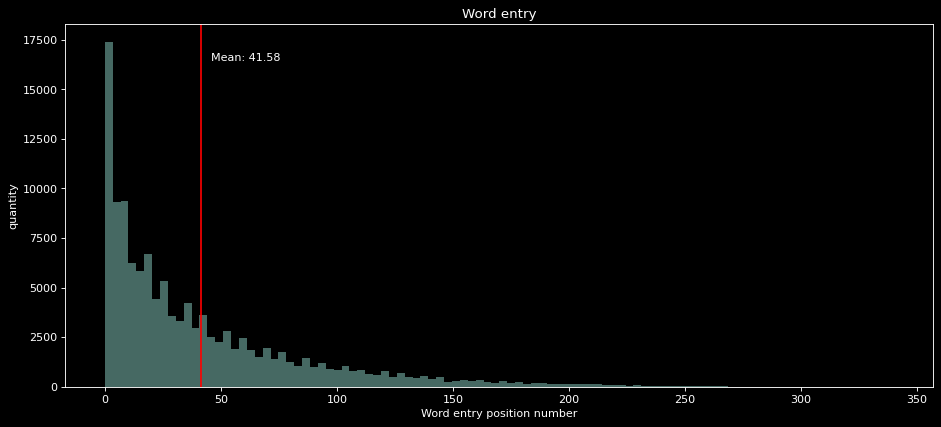

In [0]:
plt.style.use('dark_background')
figure(num=None, figsize=(14, 6), dpi=80, edgecolor='k')

plt.axvline(x=np.mean(spans), color='red', linestyle='-')
plt.hist(spans, bins=100, alpha=0.5,
            histtype='stepfilled',
            edgecolor='none')
plt.title("Word entry")
plt.ylabel('quantity')
plt.xlabel('Word entry position number')

min_ylim, max_ylim = plt.ylim()
plt.text(np.mean(spans)*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(np.mean(spans)));

## Title and abstract lenghts

In [0]:
abstract_lens = [len(splited_abstracts[i]) for i in range(len(splited_abstracts))]
title_lens = [len(splited_titles[i]) for i in range(len(splited_titles))]

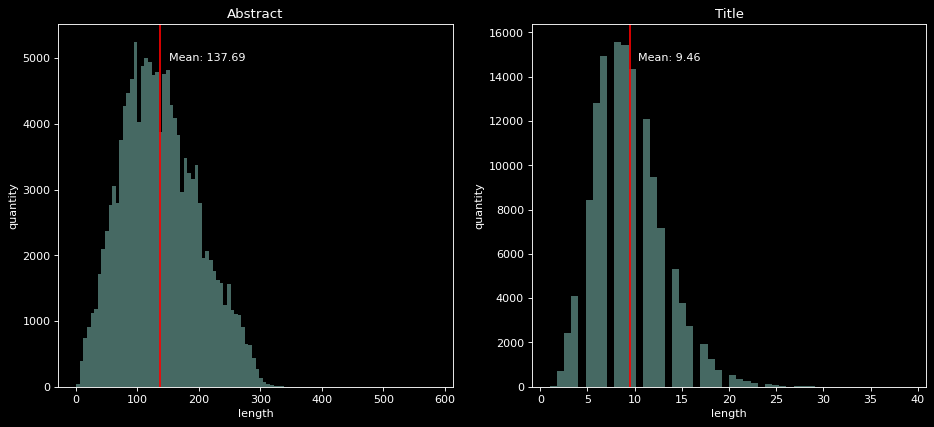

In [0]:
plt.style.use('dark_background')

figure(num=None, figsize=(14, 6), dpi=80, edgecolor='k')

plt.subplot(1, 2, 1)
plt.axvline(x=np.mean(abstract_lens), color='red', linestyle='-')
plt.hist(abstract_lens, bins=100, alpha=0.5,
            histtype='stepfilled',
            edgecolor='none')
plt.title("Abstract")
plt.ylabel('quantity')
plt.xlabel('length')

min_ylim, max_ylim = plt.ylim()
plt.text(np.mean(abstract_lens)*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(np.mean(abstract_lens)));

plt.subplot(1, 2, 2)
plt.axvline(x=np.mean(title_lens), color='red', linestyle='-')
plt.hist(title_lens, bins=50, alpha=0.5,
            histtype='stepfilled',
            edgecolor='none')
plt.title("Title")
plt.ylabel('quantity')
plt.xlabel('length')

min_ylim, max_ylim = plt.ylim()
plt.text(np.mean(title_lens)*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(np.mean(title_lens)));

## Count data Languages




In [0]:
def get_language(text):
    return Detector("".join(x for x in text if x.isprintable()), quiet=True).languages[0].name

train_df["lang"] = train_df["abstract"].progress_apply(get_language)

 49%|████▉     | 66002/135000 [00:09<00:09, 7109.45it/s]Detector is not able to detect the language reliably.
Detector is not able to detect the language reliably.
100%|██████████| 135000/135000 [00:19<00:00, 7097.62it/s]


In [0]:
lang_list = sorted(list(set(train_df["lang"])))
counts = [list(train_df["lang"]).count(cont) for cont in lang_list]
df = pd.DataFrame(np.transpose([lang_list, counts]))
df.columns = ["Language", "Count"]
df["Count"] = df["Count"].apply(int)

df_en = pd.DataFrame(np.transpose([["English", "Non-English"], [max(counts), sum(counts) - max(counts)]]))
df_en.columns = ["Language", "Count"]

fig = px.bar(df_en, x="Language", y="Count", title="Language of comments", color="Language", text="Count")
fig.update_layout(template="plotly_dark")
fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
fig.data[0].marker.line.width = 0.5
fig.data[1].marker.line.color = 'rgb(0, 0, 0)'
fig.data[1].marker.line.width = 0.5
fig.data[0].textfont.color = "black"
fig.data[0].textposition = "outside"
fig.data[1].textfont.color = "black"
fig.data[1].textposition = "outside"
fig

## How many tokens from the titles are not in the abstract?

In [0]:
def tokens_not_in_abstract(source, target):
    percents = dict()
    cnt = 0
    for _ in range(len(source)):
        for tkn in target[_]:
            if tkn not in source[_]:
                cnt+=1
        percents[_] =100*cnt/len(target[_])
        cnt=0
    return percents
        
not_in_abstract = tokens_not_in_abstract(splited_abstracts, splited_titles)

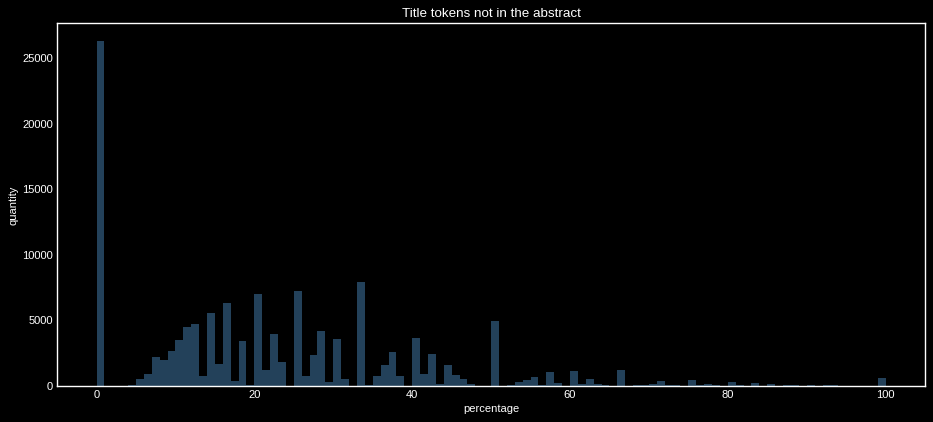

In [0]:
plt.style.use('dark_background')

figure(num=None, figsize=(14, 6), dpi=80, edgecolor='k')

plt.hist(not_in_abstract.values(), bins=100, alpha=0.5,
            histtype='stepfilled', color='steelblue',
            edgecolor='none')
plt.title("Title tokens not in the abstract") 
plt.xlabel("percentage")            
plt.ylabel("quantity"); 

## Word frequencies


In [0]:
def word_freqs(tokenized_texts):
    word_counts = collections.defaultdict(int)
    doc_n = 0

    # посчитать количество документов, в которых употребляется каждое слово
    # а также общее количество документов
    for txt in tokenized_texts:
        doc_n += 1
        unique_text_tokens = set(txt)
        for token in unique_text_tokens:
            word_counts[token] += 1

    # отсортировать слова по убыванию частоты
    sorted_word_counts = sorted(word_counts.items(),
                                reverse=True,
                                key=lambda pair: pair[1])
    # нумеруем слова
    word2id = {word: i for i, (word, _) in enumerate(sorted_word_counts)}

    # нормируем частоты слов
    word2freq = {word: cnt for word, cnt in sorted_word_counts}

    return word2id, word2freq

word_to_id_src, word_doc_freq_src = word_freqs(splited_abstracts)
word_to_id_trg, word_doc_freq_trg = word_freqs(splited_titles)

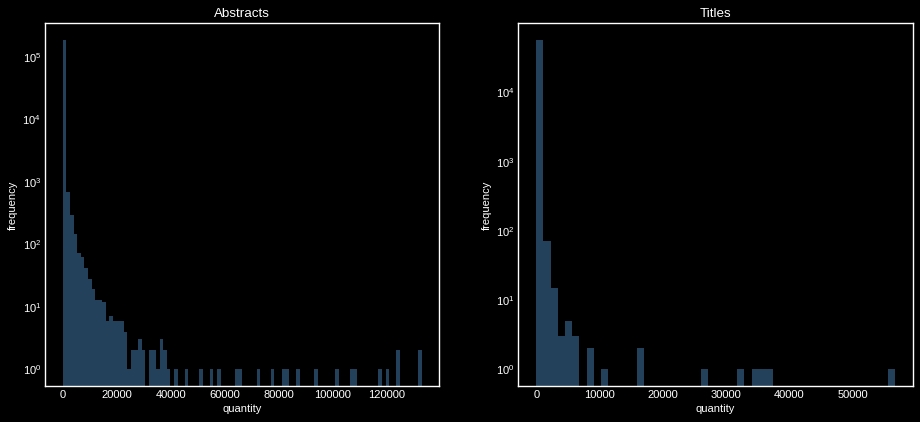

In [0]:
plt.style.use('dark_background')

figure(num=None, figsize=(14, 6), dpi=80, edgecolor='k')

plt.subplot(1, 2, 1)
plt.hist(word_doc_freq_src.values(), bins=100, alpha=0.5,
            histtype='stepfilled', color='steelblue',
            edgecolor='none')
plt.title("Abstracts")
plt.ylabel('frequency')
plt.xlabel('quantity')
plt.yscale('log')

min_ylim, max_ylim = plt.ylim();

plt.subplot(1, 2, 2)
plt.hist(word_doc_freq_trg.values(), bins=50, alpha=0.5,
            histtype='stepfilled', color='steelblue',
            edgecolor='none')
plt.title("Titles")
plt.ylabel('frequency')
plt.xlabel('quantity')
plt.yscale('log')

min_ylim, max_ylim = plt.ylim();

## Cut abstracts


In [0]:
filtred_df = pd.DataFrame({'abstract' : [' '.join(splited_abstracts[i][0:150]) for i in range(len(splited_abstracts))],
                          'title' :  [' '.join(splited_titles[i][0:25]) for i in range(len(splited_titles))]})

filtred_df.to_csv('/content/drive/My Drive/filtred_train.csv', index=False)

## Create iterators

In [10]:
tokenizer = BartTokenizer.from_pretrained('bart-large-cnn')
vocab_keys = tokenizer.get_vocab().keys()

def tokenize(text):
  """
  Tokenizes English text from a string into a list of strings (tokens)
  """
  return [token for token in tokenizer.tokenize(text) if token in vocab_keys]

In [0]:
TEXT = Field(tokenize=tokenize,
             init_token='<s>',
             eos_token="</s>",
             unk_token="<unk>",
             pad_token="<pad>",
             batch_first = True)

trn_data_fields = [("src", TEXT),
                   ("trg", TEXT)]

dataset = data.TabularDataset(
    path='/content/drive/My Drive/filtred_train.csv',
    format='csv',
    skip_header=True,
    fields=trn_data_fields
)

train_data, valid_data, test_data = dataset.split(split_ratio=[0.98, 0.01, 0.01])

In [12]:
TEXT.build_vocab() #, vectors='glove.840B.300d', vectors='fasttext.en.300d'

TEXT.vocab.stoi = tokenizer.get_vocab()

TEXT.vocab.itos = TEXT.vocab.stoi.keys()

print(f"Unique tokens in vocabulary: {len(TEXT.vocab)}")

Unique tokens in vocabulary: 50265


In [0]:
BATCH_SIZE = 5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     sort_within_batch = True,
     sort_key = lambda x : len(x.src),
     shuffle=True,
     device = device)

## Modeling

In [0]:
 def make_mask(seq, seq_pad_idx, device):
        
        #seq = [batch size, seq len]
        
        mask = (seq != seq_pad_idx).to(device)

        #seq_mask = [batch size, seq len]

        return mask

In [15]:
model = BartForConditionalGeneration.from_pretrained('bart-large-cnn').to(device)

In [16]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 406,290,432 trainable parameters


In [0]:
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

In [0]:
LEARNING_RATE = 0.00001

optimizer = AdamW(model.parameters(), lr = LEARNING_RATE)

In [0]:
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

## Обучение модели

In [0]:
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14, "ytick.color" : "w", "xtick.color" : "w"})
import matplotlib.pyplot as plt
plt.style.use('dark_background')
%matplotlib inline
from IPython.display import clear_output

def train(model, iterator, optimizer, criterion, clip, pad_idx, device, train_history=None, valid_history=None):
    
    model.train()
    
    epoch_loss = 0
    
    history = []

    for i, batch in enumerate(iterator):

      src = batch.src
      trg = batch.trg
      #trg = [batch size, trg len]
      src_mask = make_mask(src, pad_idx, device)
      trg_mask = make_mask(trg[:,:-1], pad_idx, device)

      optimizer.zero_grad()

      output = model(input_ids=src, 
                        attention_mask = src_mask, 
                        decoder_input_ids = trg[:,:-1],
                        decoder_attention_mask = trg_mask)
      
      #output = [batch size, trg len - 1, output dim]

      output_dim = output[0].shape[-1]
            
      output = output[0].contiguous().view(-1, output_dim)
      trg = trg[:,1:].contiguous().view(-1)

      loss = criterion(output, trg)
      
      loss.backward()

      torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
      
      optimizer.step()

      epoch_loss += loss.item()
        
      history.append(loss.cpu().data.numpy())
        
      if (i+1)%10==0:
          fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

          clear_output(True)
          ax[0].plot(history)
          ax[0].set_xlabel('Batch')
          ax[0].set_title('Train loss')
          if train_history is not None:
              ax[1].plot(train_history, label='general train history')
              ax[1].set_xlabel('Epoch')
              ax[1].set_title('Valid loss')
          if valid_history is not None:
              ax[1].plot(valid_history, label='general valid history')
          plt.legend()
            
          plt.show()
    return epoch_loss / len(iterator)

In [0]:
def evaluate(model, iterator, criterion, pad_idx, device):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            src_mask = make_mask(src, pad_idx, device)
            trg_mask = make_mask(trg[:,:-1], pad_idx, device)

            output = model(input_ids=src, 
                        attention_mask = src_mask, 
                        decoder_input_ids = trg[:,:-1],
                        decoder_attention_mask = trg_mask)
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output[0].shape[-1]
            
            output = output[0].contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [0]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [0]:
MODEL_NAME = '/content/drive/My Drive/BART_CNN_large_data.pt'

In [24]:
model.load_state_dict(torch.load(MODEL_NAME))

<All keys matched successfully>

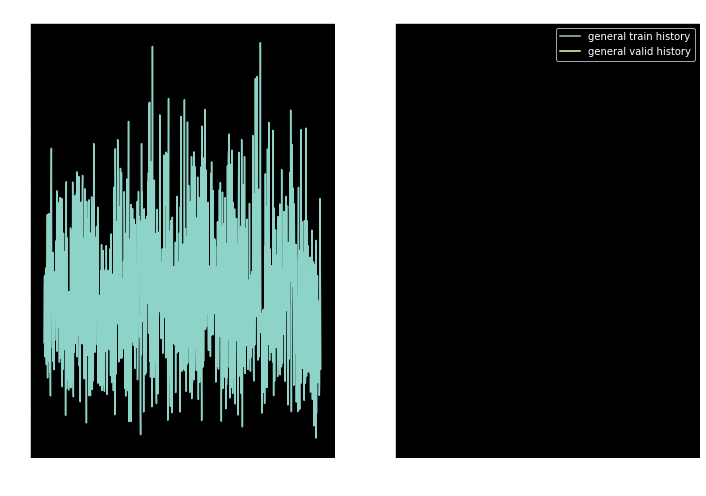

In [0]:
# to get results like in leaderboard train the model
# for 10 epochs on the whole dataset (135000 samples instead of 30000)

N_EPOCHS = 15
CLIP = 1

train_history = []
valid_history = []
history = {}

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, PAD_IDX, device, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion, PAD_IDX, device)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), MODEL_NAME)
        
    history[epoch] = [train_loss, valid_loss]
    pd.DataFrame(history).to_csv('/content/drive/My Drive/BART_history.csv')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
  
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [26]:
# for cpu usage  
#model.load_state_dict(torch.load(MODEL_NAME, map_location=torch.device('cpu'))) 
    
# for gpu usage   

#model.load_state_dict(torch.load(MODEL_NAME)) # map_location=torch.device('cuda')

test_loss = evaluate(model, test_iterator, criterion, PAD_IDX, device)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.401 | Test PPL:   4.061 |


## Генерация заголовков

In [27]:
example_idx = 8

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['pro', 'te', 'ins', 'Ġemploy', 'Ġthe', 'Ġinformation', 'Ġstored', 'Ġin', 'Ġthe', 'Ġgenetic', 'Ġcode', 'Ġand', 'Ġtranslated', 'Ġinto', 'Ġtheir', 'Ġsequences', 'Ġto', 'Ġcarry', 'Ġout', 'Ġwell', '-', 'defined', 'Ġfunctions', 'Ġin', 'Ġthe', 'Ġcellular', 'Ġenvironment', '.', 'Ġthe', 'Ġpossibility', 'Ġto', 'Ġencode', 'Ġfor', 'Ġsuch', 'Ġfunctions', 'Ġis', 'Ġcontrolled', 'Ġby', 'Ġthe', 'Ġbalance', 'Ġbetween', 'Ġthe', 'Ġamount', 'Ġof', 'Ġinformation', 'Ġsupplied', 'Ġby', 'Ġthe', 'Ġsequence', 'Ġand', 'Ġthat', 'Ġleft', 'Ġafter', 'Ġthat', 'Ġthe', 'Ġprotein', 'Ġhas', 'Ġfolded', 'Ġinto', 'Ġits', 'Ġstructure', '.', 'Ġwe', 'Ġdeveloped', 'Ġa', 'Ġcomputational', 'Ġalgorithm', 'Ġto', 'Ġevaluate', 'Ġthe', 'Ġamount', 'Ġof', 'Ġinformation', 'Ġnecessary', 'Ġto', 'Ġspecify', 'Ġthe', 'Ġprotein', 'Ġstructure', ',', 'Ġkeeping', 'Ġinto', 'Ġaccount', 'Ġthe', 'Ġtherm', 'odynamic', 'Ġproperties', 'Ġof', 'Ġprotein', 'Ġfolding', '.', 'Ġwe', 'Ġthus', 'Ġshow', 'Ġthat', 'Ġthe', 'Ġinformation', 'Ġremaining', 'Ġin',

In [28]:
inputs =  torch.tensor([TEXT.vocab.stoi[token] for token in src]).unsqueeze(0).to(device)
# Generate Summary
summary_ids = model.generate(inputs, num_beams=10, bad_words_ids=[[32099]])
print([tokenizer.decode(i_d, skip_special_tokens=True, clean_up_tokenization_spaces=False) for i_d in summary_ids])

['determining the information contained in a protein sequence from its information gap: an information-theoretic approach to the prediction of the information needed to encode and unfold the information for its structure, using the information gap between its sequence and its interaction with ordered and disordered proteins']


In [37]:
for example_idx in range(8):
    src = vars(test_data.examples[example_idx])['src']
    trg = vars(test_data.examples[example_idx])['trg']
    trg = tokenizer.convert_tokens_to_string(trg)
    inputs =  torch.tensor([TEXT.vocab.stoi[token] for token in src]).unsqueeze(0).to(device)
    summary_ids = model.generate(inputs, num_beams=5, max_length=16, early_stopping=True)
    translation = [tokenizer.decode(i_d, skip_special_tokens=True, clean_up_tokenization_spaces=False) for i_d in summary_ids]

    print('Оригинальный заголовок: ', ''.join(trg))
    print('Предсказанный заголовок: ', ' '.join(translation))
    print('-----------------------------------')

Оригинальный заголовок:  diversity and its decomposition into variety, balance and disparity
Предсказанный заголовок:  measuring diversity and its decomposition into variety, balance and disparity
-----------------------------------
Оригинальный заголовок:  improving the johnson-lindenstrauss lemma
Предсказанный заголовок:  improving the johnson-lindenstrauss lemma
-----------------------------------
Оригинальный заголовок:  the mean-field approximation model of company's income growth
Предсказанный заголовок:  mean-field approximation of income distribution in company's company's business
-----------------------------------
Оригинальный заголовок:  efficient inference of protein structural ensembles
Предсказанный заголовок:  one-parameter models of protein ensembles with native state
-----------------------------------
Оригинальный заголовок:  financial black swans driven by ultrafast machine ecology
Предсказанный заголовок:  ultrafast black swan events and their impact on stock-
----

## Считаем BLEU

In [0]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

In [0]:
bleu_score = calculate_bleu(test_data, , TEXT, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

## Делаем submission в Kaggle

In [0]:
#test_tokenized_abstract = [tokenize(title) for title in submission_data['abstract']]
#test_abstract_lens = [len(test_tokenized_abstract[i]) for i in range(len(test_tokenized_abstract))]

In [0]:
import pandas as pd
import string

submission_data = pd.read_csv('/content/drive/My Drive/test.csv')

pattern = r'\S+'

splited_test = [re.findall(pattern, abstract) for abstract in submission_data['abstract']]
splited_test = [[token for token in splited_test[i] if len(token)<=22] for i in range(len(splited_test))]

#filtred_test = pd.DataFrame({'abstract' : [' '.join(splited_test[i]) for i in range(len(splited_test))]})

#pattern = r"\w+-\w+-\w+|\w+-\w+|\w+'\w+|\w+"

#splited_test = [re.findall(pattern, abstract) for abstract in filtred_test['abstract']]

test_df = pd.DataFrame({'abstract': [' '.join(splited_test[i][0:200]) for i in range(len(splited_test))]})

abstracts = test_df['abstract'].values

In [44]:
from IPython.display import clear_output

titles = []
for number , abstract in enumerate(abstracts):
    abstract = tokenizer.tokenize(abstract)
    abstract = torch.tensor([TEXT.vocab.stoi[token] for token in abstract if token in TEXT.vocab.itos]).unsqueeze(0).to(device)
    title = model.generate(abstract, num_beams=1, min_length=2, max_length=20) 
    titles.append([tokenizer.decode(i_d, skip_special_tokens=True, clean_up_tokenization_spaces=False) for i_d in title][0])
    print(f'titles generaited: {number+1}')
    clear_output(wait=True)

titles generaited: 1000


Записываем полученные заголовки в файл формата `<abstract>,<title>`:

In [0]:
submission_df = pd.DataFrame({'abstract': abstracts, 'title': titles})
submission_df.to_csv('predicted_titles.csv', index=False)

С помощью функции `generate_csv` приводим файл `submission_prediction.csv` в формат, необходимый для посылки в соревнование на Kaggle:

In [46]:
import string
from nltk.util import ngrams
import numpy as np
import pandas as pd
import pickle


def generate_csv(input_file='predicted_titles.csv',
                 output_file='submission.csv',
                 voc_file='/content/drive/My Drive/vocs.pkl'):
    '''
    Generates file in format required for submitting result to Kaggle
    
    Parameters:
        input_file (str) : path to csv file with your predicted titles.
                           Should have two fields: abstract and title
        output_file (str) : path to output submission file
        voc_file (str) : path to voc.pkl file
    '''
    data = pd.read_csv(input_file)
    with open(voc_file, 'rb') as voc_file:
        vocs = pickle.load(voc_file)

    with open(output_file, 'w') as res_file:
        res_file.write('Id,Predict\n')
        
    output_idx = 0
    for row_idx, row in data.iterrows():
        trg = row['title']
        trg = trg.translate(str.maketrans('', '', string.punctuation)).lower().split()
        try:
            trg.extend(['_'.join(ngram) for ngram in list(ngrams(trg, 2)) + list(ngrams(trg, 3))])
        except:
            continue
        VOCAB_stoi = vocs[row_idx]
        trg_intersection = set(VOCAB_stoi.keys()).intersection(set(trg))
        trg_vec = np.zeros(len(VOCAB_stoi))    

        for word in trg_intersection:
            trg_vec[VOCAB_stoi[word]] = 1

        with open(output_file, 'a') as res_file:
            for is_word in trg_vec:
                res_file.write('{0},{1}\n'.format(output_idx, int(is_word)))
                output_idx += 1


generate_csv()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: DeprecationWarning:

generator 'ngrams' raised StopIteration

